In [2]:
import os 
os.getcwd()

import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.special import rel_entr
from scipy.stats import entropy

from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

from sklearn.model_selection import KFold

pd.set_option('display.max_columns', None)

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

Output Dir:  ./outputs/


In [3]:
def get_non_overlap(train_csv, targets):

    df = train_csv.groupby(['eeg_id'] + targets).agg({
            'spectrogram_id': 'first',
            'spectrogram_label_offset_seconds': ['min', 'max'],
            'eeg_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)],
            'patient_id': 'first',
            'expert_consensus': 'first',
            'total_votes': 'sum',
            'entropy': 'mean',
            'is_hard': 'mean'
        }).reset_index()

    df.columns = ["eeg_id"] + targets + \
        ['spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'eeg_off_sample', 'patient_id', 'target', 'total_votes', 'average_entropy', 'is_hard']

    df[targets] = df[targets].apply(lambda x: x / x.sum(), axis=1)

    return df

In [10]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

print("targets: ", targets)

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

train_csv['rel_entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)
train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: entropy(row.values+1e-5), axis=1)

train_csv['is_hard'] = (train_csv['rel_entropy'] < 5.5).astype(int)

agg_dicts = {
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': ['min', 'max'],
    'eeg_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)],
    'patient_id': 'first',
    'expert_consensus': 'first',
    'total_votes': 'sum',
    'entropy': 'mean',
    'is_hard': 'mean'
}

for col in targets:
    agg_dicts[col] = 'sum'

train_all = train_csv.groupby(['eeg_id']+targets_prob).agg(agg_dicts).reset_index()

col_names = [
    'spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'eeg_off_sample', 
    'patient_id', 'target', 'total_votes', 'entropy', 'is_hard'
    ] + targets

train_all.columns = ["eeg_id"] + targets_prob + col_names
train_all.drop(targets_prob, axis=1, inplace=True)
train_all[targets] = train_all[targets].div(train_all['total_votes'], axis=0)
train_all['is_stage'] = 1
train_all.loc[(train_all['total_votes']>10) | (train_all['entropy']<5.5), 'is_stage'] = 2

K_FOLDS = 5
unique_eegs = train_all['eeg_id'].unique()
kf = KFold(n_splits=K_FOLDS)

train_all['fold'] = -1

for fold, (train_index, valid_index) in enumerate(kf.split(unique_eegs)):
    train_all.loc[train_all['eeg_id'].isin(unique_eegs[valid_index]), 'fold'] = fold

print("train_all: ", train_all.shape)
for fold in range(K_FOLDS):
    train_size = train_all[train_all['fold'] != fold].shape[0]
    valid_size = train_all[train_all['fold'] == fold].shape[0]
    train_hard_size = train_all[(train_all['fold'] != fold) & (train_all['is_stage'] == 2)].shape[0]
    valid_hard_size = train_all[(train_all['fold'] == fold) & (train_all['is_stage'] == 2)].shape[0]
    print(f"Fold {fold}: All Size: {train_size} | {valid_size}, Hard Size: {train_hard_size} | {valid_hard_size}")

train_all.head(15)

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_all:  (19763, 20)
Fold 0: All Size: 15754 | 4009, Hard Size: 15754 | 4009
Fold 1: All Size: 15812 | 3951, Hard Size: 15812 | 3951
Fold 2: All Size: 15844 | 3919, Hard Size: 15844 | 3919
Fold 3: All Size: 15805 | 3958, Hard Size: 15805 | 3958
Fold 4: All Size: 15837 | 3926, Hard Size: 15837 | 3926


,eeg_id,spectrogram_id,min,max,eeg_off_min,eeg_off_max,eeg_off_sample,patient_id,target,total_votes,entropy,is_hard,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,is_stage,fold
0,568657,789577333,0.0,16.0,0.0,16.0,0.0,20654,Other,48,0.959970,1.0,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,2,0
1,582999,1552638400,0.0,38.0,0.0,38.0,38.0,20230,LPD,154,0.509536,1.0,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,2,0
2,642382,14960202,1008.0,1032.0,0.0,24.0,0.0,5955,Other,2,0.000626,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2,0
3,751790,618728447,908.0,908.0,0.0,0.0,0.0,38549,GPD,1,0.000626,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2,0
4,778705,52296320,0.0,0.0,0.0,0.0,0.0,40955,Other,2,0.000626,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2,0
5,1629671,2036345030,0.0,160.0,0.0,160.0,120.0,37481,Seizure,51,0.000626,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0
6,1895581,128369999,1138.0,1138.0,0.0,0.0,0.0,47999,Other,13,0.536357,1.0,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,2,0
7,2061593,320962633,1450.0,1450.0,0.0,0.0,0.0,23828,Other,1,0.000626,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2,0
8,2078097,2074135650,3342.0,3342.0,0.0,0.0,0.0,61174,Other,2,0.000626,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2,0
9,2366870,1232582129,0.0,30.0,0.0,30.0,22.0,23633,Other,18,0.636992,0.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,2,0


In [28]:
train_all[(train_all['is_hard'] == 1)  | (train_all['entropy'] > 0.65)]['target'].value_counts() 

target
Other      1762
LPD        1217
Seizure     801
GPD         689
GRDA        523
LRDA        468
Name: count, dtype: int64

In [29]:
train_all[(train_all['is_hard'] == 1)]['target'].value_counts() 

target
Other      1546
LPD         907
GPD         542
Seizure     440
LRDA        344
GRDA        315
Name: count, dtype: int64

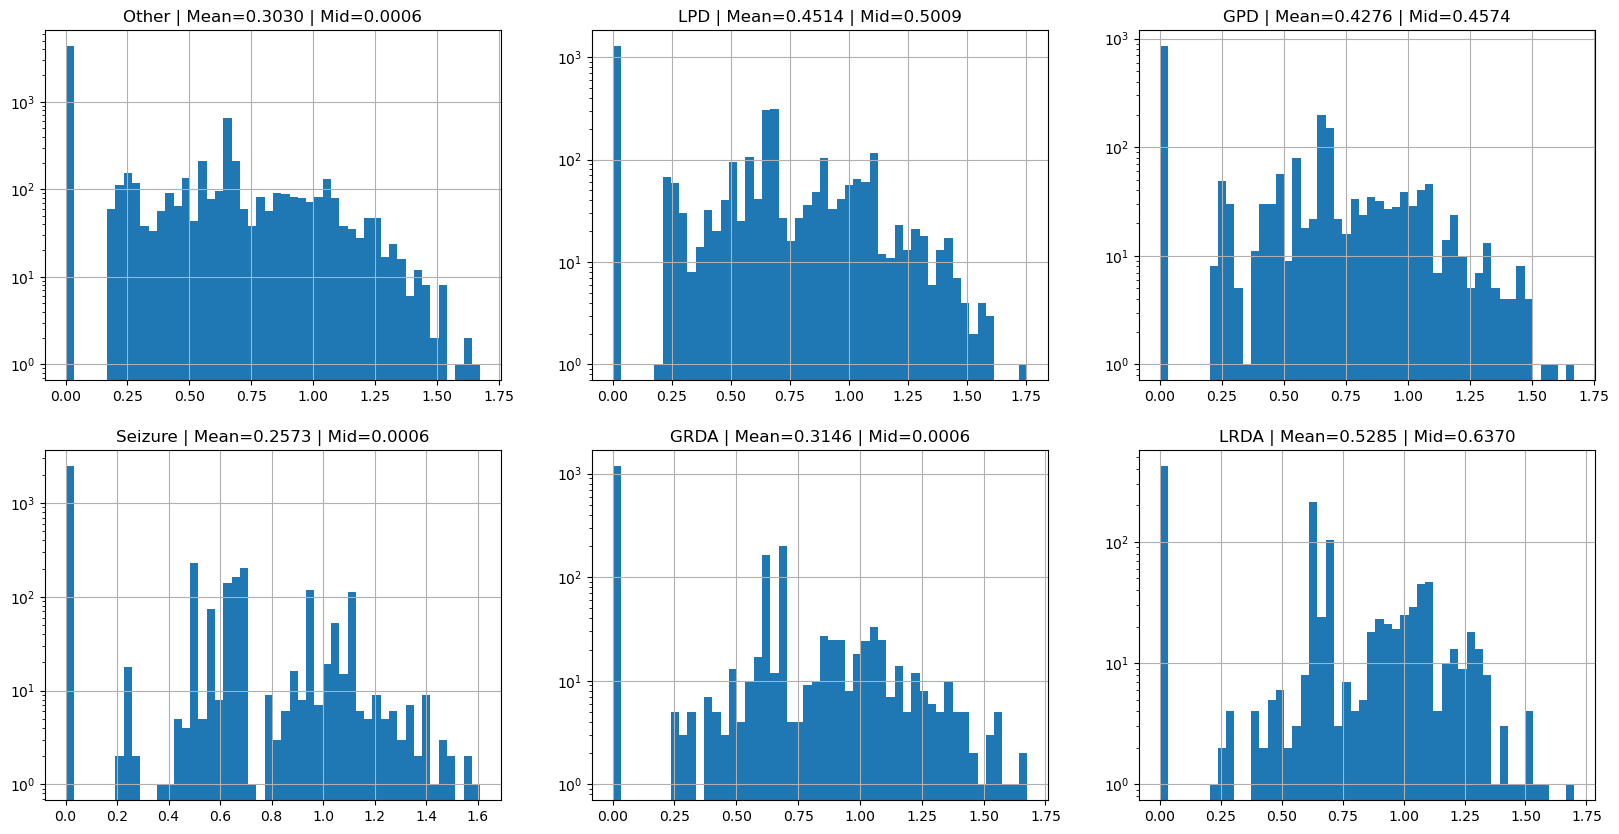

In [19]:
# plot in 2x3 grid the histogram of entropy for each target
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
brain_actities = train_all['target'].unique()
for i, target in enumerate(brain_actities):
    ax = axs[i//3, i%3]
    _df = train_all[train_all['target'] == target]
    ax.hist(_df['entropy'], bins=50, log=True)
    ax.set_title(f"{target} | Mean={_df['entropy'].mean():.4f} | Mid={_df['entropy'].median():.4f}")
    ax.grid()
plt.show()

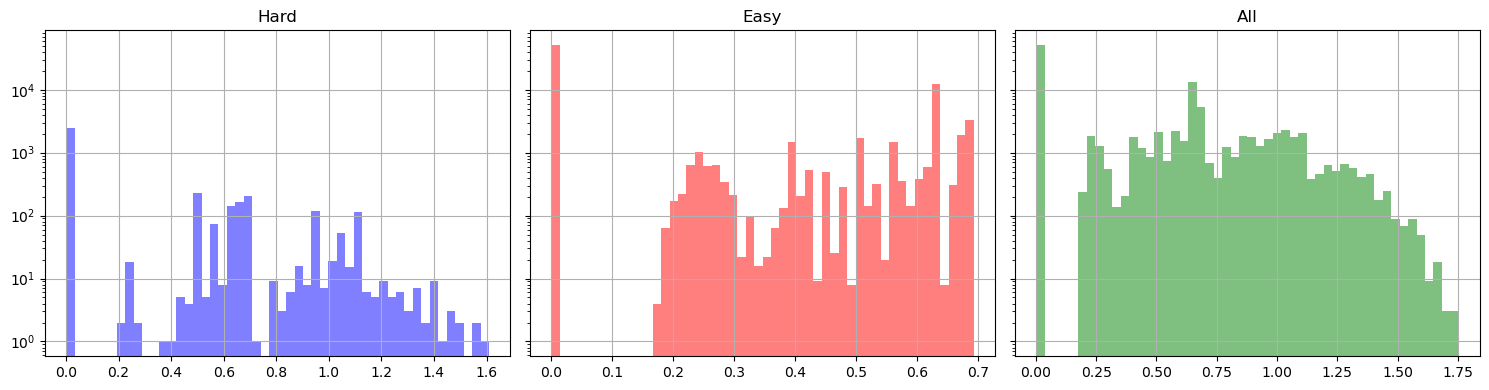

In [12]:
# plot entropy distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
# plt.hist(train_csv['entropy'], bins=50, log=True)
axes[2].hist(train_csv['entropy'], bins=50, log=True, alpha=0.5, label='All', color='green')
axes[2].set_title('All')

axes[0].hist(train_all[train_all['target']=='Seizure']['entropy'], bins=50, log=True, alpha=0.5, label='Hard', color='blue')
axes[1].hist(train_csv[train_csv['is_hard']==0]['entropy'], bins=50, log=True, alpha=0.5, label='Easy', color='red')
axes[0].set_title('Hard')
axes[1].set_title('Easy')
for ax in axes:
    # ax.set_xlim(0, 2)
    ax.grid()
fig.tight_layout()
plt.show()

In [101]:
train_all[train_all['entropy']>0.65].shape #[targets].sample(1).T.plot(kind='line', legend=False, figsize=(6, 4))

(5059, 20)

In [100]:
train_all[train_all['entropy']<0.65].shape #[targets].sample(1).T.plot(kind='line', legend=False, figsize=(6, 4))

(14704, 20)

In [102]:
14704 / (14704 + 5059)

0.744016596670546

In [60]:
oof_df = pd.read_csv("/home/shiyi/kaggle_hms/outputs/EEGSeq_DilatedResNet_Deep_oof_1.csv")
oof_df 

,eeg_id,spectrogram_id,min,max,eeg_off_min,eeg_off_max,eeg_off_sample,patient_id,target,total_votes,entropy,is_hard,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,is_stage,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred
0,568657,789577333,0.0,16.0,0.0,16.0,0.0,20654,Other,48,4.584192,1.0,0.0,0.000000,0.25,0.000000,0.166667,0.583333,2,0,0.290366,-0.027439,-0.374498,-0.602227,0.025486,0.290855
1,582999,1552638400,0.0,38.0,0.0,38.0,22.0,20230,LPD,154,4.870032,1.0,0.0,0.857143,0.00,0.071429,0.000000,0.071429,2,0,0.776828,-0.146967,-2.640916,0.446970,-0.943627,1.843312
2,642382,14960202,1008.0,1032.0,0.0,24.0,24.0,5955,Other,2,7.802343,0.0,0.0,0.000000,0.00,0.000000,0.000000,1.000000,1,0,-2.276082,-2.140028,-2.107185,1.583345,1.186020,3.752944
3,751790,618728447,908.0,908.0,0.0,0.0,0.0,38549,GPD,1,7.802343,0.0,0.0,0.000000,1.00,0.000000,0.000000,0.000000,1,0,-0.750274,2.926679,5.136153,-3.356905,-3.394919,-1.107037
4,778705,52296320,0.0,0.0,0.0,0.0,0.0,40955,Other,2,7.802343,0.0,0.0,0.000000,0.00,0.000000,0.000000,1.000000,1,0,0.655249,-0.716467,-2.706050,0.735582,-0.388100,1.260881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19758,4293354003,1188113564,0.0,0.0,0.0,0.0,0.0,16610,GRDA,2,6.114567,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.500000,1,4,-1.880979,-0.540863,-3.115792,1.275536,1.343544,2.388425
19759,4293843368,1549502620,0.0,0.0,0.0,0.0,0.0,15065,GRDA,2,6.114567,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.500000,1,4,-0.194038,-0.567151,-1.522265,0.157967,0.249286,1.172498
19760,4294455489,2105480289,0.0,0.0,0.0,0.0,0.0,56,Other,1,7.802343,0.0,0.0,0.000000,0.00,0.000000,0.000000,1.000000,1,4,-0.031874,0.107047,-0.960025,-0.989744,-0.715511,1.952099
19761,4294858825,657299228,0.0,12.0,0.0,12.0,8.0,4312,Other,75,6.346338,0.0,0.0,0.000000,0.00,0.000000,0.066667,0.933333,2,4,-0.088146,0.284361,-3.237488,1.793840,-0.008674,1.070638


In [132]:
from scipy.special import softmax

label_to_idx = {label: idx for idx, label in enumerate(targets)}

# tmp_focal_loss = pd.concat([
#     train_all[train_all['is_hard']==1].sample(5)[targets],
#     train_all[train_all['is_hard']==0].sample(5)[targets]
# ])
n_samples = 100
targets_pred = [f"{col.split('_')[0]}_pred" for col in targets]
tmp_focal_loss = oof_df.sample(n_samples)[['eeg_id'] + targets + targets_pred].reset_index(drop=True)
y_preds = softmax(tmp_focal_loss[targets_pred].values, axis=1)
tmp_focal_loss[targets_pred] = y_preds

display(tmp_focal_loss.head())

tmp_focal_loss['true_label'] = tmp_focal_loss[targets].idxmax(axis=1).map(label_to_idx)
true_labes_one_hot = np.eye(6)[tmp_focal_loss['true_label'].values]

# y_preds = softmax(np.random.standard_normal((len(tmp_focal_loss), len(targets))), axis=1)
# tmp_focal_loss[targets] = y_preds

tmp_focal_loss['entropy'] = tmp_focal_loss[targets_pred].apply(lambda row: entropy(row.values+1e-10), axis=1)
tmp_focal_loss['kl_loss'] = np.sum(rel_entr(tmp_focal_loss[targets].values, tmp_focal_loss[targets_pred].values), axis=1)
tmp_focal_loss['reg_kl_loss'] = tmp_focal_loss['kl_loss'] - 2*tmp_focal_loss['entropy']

tmp_focal_loss['pred_label'] = tmp_focal_loss[targets_pred].idxmax(axis=1).map({label: idx for idx, label in enumerate(targets_pred)})

gamma = 2
alpha_0 = 0.25
k = 2

# calc_alpha = lambda x: min(1, alpha_0+k*x)
tmp_focal_loss['alpha'] = tmp_focal_loss['entropy'].apply(lambda x: 0.25 if x<0.65 else 0.75)

pt = np.where(true_labes_one_hot==1, y_preds, 1-y_preds)
tmp_focal_loss[[f"{col}_pt" for col in targets]] = pt

focal_loss = -tmp_focal_loss['alpha'].values[:, np.newaxis] * (1 - pt)**gamma * np.log(pt)
tmp_focal_loss['focal_loss'] = np.sum(focal_loss*true_labes_one_hot, axis=1)

tmp_focal_loss['cross_entropy'] = (tmp_focal_loss[targets].values * np.log(tmp_focal_loss[targets_pred].values+1e-5)).sum(axis=1)

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred
0,4092290764,0.0,0.0,0.0,0.0,0.0,1.0,0.115573,0.272360,0.036164,0.093408,0.064390,0.418106
1,3566576347,0.0,0.0,0.0,1.0,0.0,0.0,0.291647,0.064361,0.009431,0.148366,0.049358,0.436836
2,383314548,0.6,0.0,0.2,0.0,0.0,0.2,0.622048,0.091620,0.100404,0.021926,0.022491,0.141510
3,1839853877,0.0,1.0,0.0,0.0,0.0,0.0,0.040976,0.698905,0.110520,0.010497,0.008237,0.130865
4,1556041696,0.6,0.0,0.0,0.0,0.0,0.4,0.250922,0.063846,0.060971,0.061323,0.108149,0.454789


In [133]:
print(tmp_focal_loss['focal_loss'].mean())
tmp_focal_loss

0.43264404303266296


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,true_label,entropy,kl_loss,reg_kl_loss,pred_label,alpha,seizure_vote_pt,lpd_vote_pt,gpd_vote_pt,lrda_vote_pt,grda_vote_pt,other_vote_pt,focal_loss,cross_entropy
0,4092290764,0.000000,0.0,0.0,0.0,0.0,1.000000,0.115573,0.272360,0.036164,0.093408,0.064390,0.418106,5,1.486338,0.872021,-2.100654,5,0.75,0.884427,0.727640,0.963836,0.906592,0.935610,0.418106,0.221450,-0.871997
1,3566576347,0.000000,0.0,0.0,1.0,0.0,0.000000,0.291647,0.064361,0.009431,0.148366,0.049358,0.436836,3,1.373296,1.908072,-0.838520,5,0.75,0.708353,0.935639,0.990569,0.148366,0.950642,0.563164,1.037915,-1.908005
2,383314548,0.600000,0.0,0.2,0.0,0.0,0.200000,0.622048,0.091620,0.100404,0.021926,0.022491,0.141510,0,1.190888,0.185360,-2.196416,0,0.75,0.622048,0.908380,0.899596,0.978074,0.977509,0.858490,0.050861,-1.135586
3,1839853877,0.000000,1.0,0.0,0.0,0.0,0.000000,0.040976,0.698905,0.110520,0.010497,0.008237,0.130865,1,0.978200,0.358241,-1.598159,1,0.75,0.959024,0.698905,0.889480,0.989503,0.991763,0.869135,0.024358,-0.358227
4,1556041696,0.600000,0.0,0.0,0.0,0.0,0.400000,0.250922,0.063846,0.060971,0.061323,0.108149,0.454789,0,1.463221,0.471724,-2.454717,5,0.75,0.250922,0.936154,0.939029,0.938677,0.891851,0.545211,0.581856,-1.144703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,522415811,1.000000,0.0,0.0,0.0,0.0,0.000000,0.382907,0.033460,0.019491,0.094723,0.166594,0.302824,0,1.441574,0.959962,-1.923185,0,0.75,0.382907,0.966540,0.980509,0.905277,0.833406,0.697176,0.274168,-0.959936
96,1695688501,0.000000,0.0,0.0,0.0,1.0,0.000000,0.090639,0.017035,0.014552,0.026144,0.091289,0.760341,4,0.870661,2.393730,0.652407,5,0.75,0.909361,0.982965,0.985448,0.973856,0.091289,0.239659,1.482478,-2.393620
97,994736746,0.000000,1.0,0.0,0.0,0.0,0.000000,0.034714,0.462565,0.006029,0.350467,0.021045,0.125179,1,1.212941,0.770968,-1.654914,1,0.75,0.965286,0.462565,0.993971,0.649533,0.978955,0.874821,0.167012,-0.770946
98,519346170,0.666667,0.0,0.0,0.0,0.0,0.333333,0.127763,0.092421,0.042663,0.093392,0.146494,0.497266,0,1.467766,0.968079,-1.967454,5,0.75,0.127763,0.907579,0.957337,0.906608,0.853506,0.502734,1.174047,-1.604534


eeg_id             2.668839e+08
seizure_vote       1.000000e+00
lpd_vote           0.000000e+00
gpd_vote           0.000000e+00
lrda_vote          0.000000e+00
grda_vote          0.000000e+00
other_vote         0.000000e+00
seizure_pred       9.110693e-02
lpd_pred           1.975465e-02
gpd_pred           8.023467e-03
lrda_pred          7.532323e-02
grda_pred          4.135375e-02
other_pred         7.644380e-01
true_label         0.000000e+00
entropy            8.663662e-01
kl_loss            2.395721e+00
reg_kl_loss        6.629889e-01
pred_label         5.000000e+00
alpha              7.500000e-01
seizure_vote_pt    9.110693e-02
lpd_vote_pt        9.802454e-01
gpd_vote_pt        9.919765e-01
lrda_vote_pt       9.246768e-01
grda_vote_pt       9.586462e-01
other_vote_pt      2.355620e-01
focal_loss         1.484305e+00
cross_entropy     -2.395612e+00
Name: 82, dtype: float64

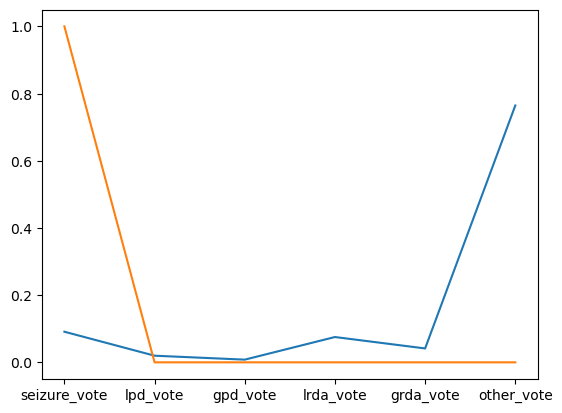

In [141]:
tmp_focal_loss.loc[tmp_focal_loss['reg_kl_loss'].idxmax(axis=0)][targets_pred].T.plot()
tmp_focal_loss.loc[tmp_focal_loss['reg_kl_loss'].idxmax(axis=0)][targets].T.plot()
tmp_focal_loss.loc[tmp_focal_loss['reg_kl_loss'].idxmax(axis=0)]
# tmp_focal_loss['kl_loss'].idxmin(axis=0)

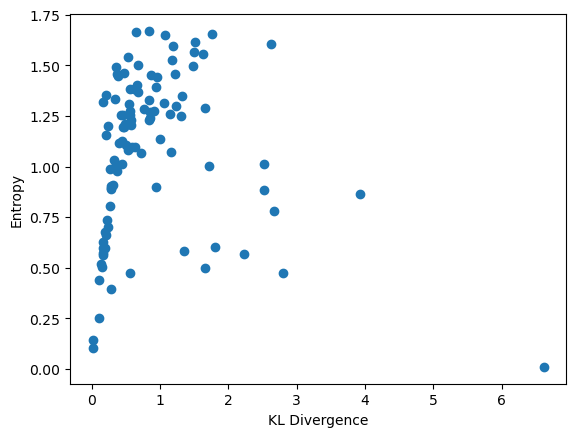

In [131]:
plt.scatter(tmp_focal_loss['kl_loss'], tmp_focal_loss['entropy'])
plt.ylabel('Entropy')
plt.xlabel('KL Divergence')
plt.show()

<Axes: title={'center': 'Total Votes Distribution'}, ylabel='Frequency'>

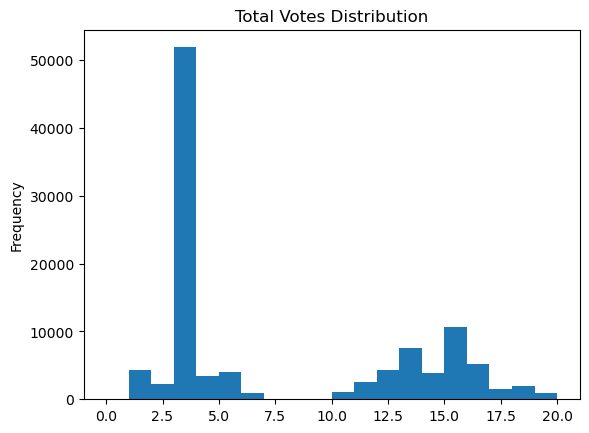

In [26]:
train_csv['total_votes'].plot(kind='hist', bins=20, title='Total Votes Distribution', range=(0, 20))

Target: Other
Target: LPD
Target: GPD
Target: Seizure
Target: GRDA
Target: LRDA


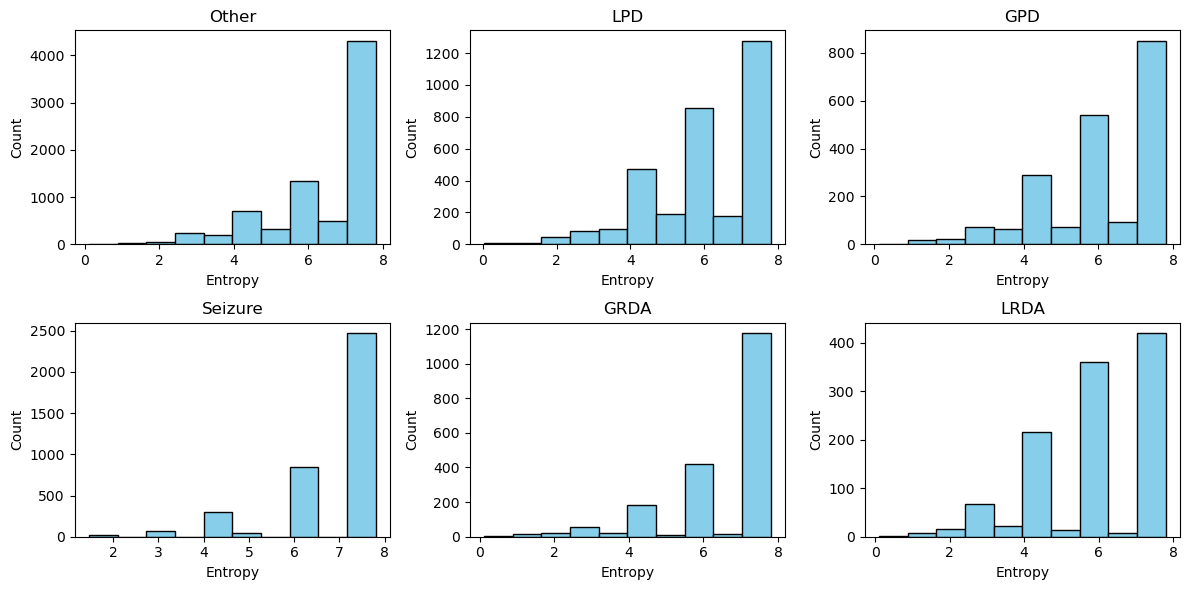

In [10]:
unique_targets = train_all['target'].unique()
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for ax, tgt in zip(axes.flatten(), unique_targets):
    print(f"Target: {tgt}")
    tmp = train_all[train_all['target'] == tgt].copy()
    # plot hist of entropy
    ax.hist(tmp['average_entropy'], bins=10, color='skyblue', edgecolor='black')
    ax.set_title(f"{tgt}")
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
train_hard = train_all[train_all['is_hard']==1]
print(train_hard.shape)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
unique_spec_id = train_all['spectrogram_id'].unique()
print("unique_spec_id: ", len(unique_spec_id))
train_all['fold'] = 5
for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
    train_all.loc[train_all['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

fold_counts = train_all['fold'].value_counts()

target_counts = train_all[train_all['fold'] == 0]['target'].value_counts()
target_counts = target_counts / target_counts.sum()

for fold in range(5):
    target_counts = train_all[train_all['fold'] != fold]['target'].value_counts()
    target_counts = target_counts / target_counts.sum()
    target_counts.plot(kind='bar')
    plt.show()
   

In [ ]:
df_sub['seizure_prob']==0

In [ ]:
tgt_list = targets.to_list()

# agg_dict = {
#         'spectrogram_id': 'first',
#         'spectrogram_label_offset_seconds': ['min', 'max'],
#         'patient_id': 'first',
#         'expert_consensus': 'first',
#         'is_hard': lambda x: x.sum() / x.count()
#     }

agg_dict = {
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': ['min', 'max'],
    'patient_id': 'first',
    'expert_consensus': ['first', 'count', 'nunique'],
    'entropy': 'mean',
    'is_hard': lambda x: x.sum() / x.count()
}

for tgt in tgt_list:
    agg_dict[tgt] = 'sum'
    
df_agg = train_csv.groupby(['eeg_id']).agg(agg_dict).reset_index()
df_agg.columns = ['eeg_id','spectrogram_id', 'min', 'max', 'patient_id', 'target', 'target_count', 'target_nunique','averge_entropy', 'is_hard_ratio'] + tgt_list

df_agg['total_votes'] = df_agg[tgt_list].sum(axis=1)
df_agg[tgt_list] = df_agg[tgt_list].apply(lambda x: x / x.sum(), axis=1)

In [ ]:
df_agg[(df_agg['target_count']>1)&(df_agg['target_nunique']>1)].sort_values('target_count', ascending=False).head(50)

In [ ]:
pd.set_option("display.max_rows", None)
df_on_eeg = train_csv[train_csv['eeg_id']==188361788].sort_values('total_votes').reset_index()
df_to_plot = df_on_eeg.groupby('expert_consensus').apply(lambda x: x.sample(1)).reset_index(drop=True)
df_to_plot #[['eeg_id', 'spectrogram_id', 'spectrogram_label_offset_seconds', 'expert_consensus', 'is_hard', 'entropy', 'total_votes'] + tgt_list ]

In [ ]:
df_on_eeg.groupby(targets.tolist()).agg({
    'spectrogram_id': 'count',
    'eeg_label_offset_seconds': ['min', 'max'],
    'spectrogram_label_offset_seconds': ['min', 'max', lambda x: x.sample(1)]
    }).reset_index()

In [ ]:
targets

In [ ]:
df_on_eeg[targets].mean(axis=0), df_on_eeg['spectrogram_label_offset_seconds'].min(), df_on_eeg['spectrogram_label_offset_seconds'].max(), df_on_eeg['eeg_label_offset_seconds'].min(), df_on_eeg['eeg_label_offset_seconds'].max()

In [ ]:
EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}
EEF_FEAT_INDEX

In [ ]:
def plot_spec(df):

    fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharex=True, sharey=True)

    prefixes = ['LL', 'RL', 'LP', 'RP']

    for ax, prefix in zip(axs.flatten(), prefixes):
        cols = df.filter(regex=f"^{prefix}_").columns
        ax.imshow(df[cols].T, origin="lower", norm="log", cmap="plasma", interpolation="none")
        ax.set_title(prefix, fontsize=12, fontweight="bold")
        ax.set_yticks(np.arange(0, 101, 25.))
        ax.set_yticklabels([0, 5, 10, 15, 20])
        ax.set_xticks(np.arange(0, 301, 75.))
        ax.set_xticklabels(range(df.iloc[0, 0], df.iloc[-1, 0], (df.iloc[-1, 0]-df.iloc[0, 0])//4))

    for ax in axs[:, 0]:
        ax.set_ylabel("Frequency (Hz)")
    for ax in axs[-1, :]:
        ax.set_xlabel("Time (s)")

    fig.tight_layout()
    plt.show()

In [ ]:
spectrogram_id = df_to_plot['spectrogram_id'].values[0]
print(spectrogram_id)

spec_parquet = pd.read_parquet(f"./inputs/hms-harmful-brain-activity-classification/train_spectrograms/{spectrogram_id}.parquet")
print(spec_parquet.shape)

for idx, row in df_to_plot.iterrows():
    start = row['spectrogram_label_offset_seconds']
    spec_part = spec_parquet[(spec_parquet['time'] >= start) & (spec_parquet['time'] <= start+600)]
    print(f"Offset: {start}; Expert Consensus: {row['expert_consensus']}")
    plot_spec(spec_part)
    print("=================================")

In [ ]:
eeg_id = df_to_plot['eeg_id'].values[0]
print(eeg_id)

ch_1, ch_2 = 'Fp1', 'T3' #'Fp1', 'C3' #'T3', 'O1' #

eeg_seq = pd.read_parquet(f"./inputs/hms-harmful-brain-activity-classification/train_eegs/{eeg_id}.parquet")
print(eeg_seq.shape)

fig, axes = plt.subplots(len(df_to_plot), 1, figsize=(10, 2*len(df_to_plot)))
i = 0
for idx, row in df_to_plot.iterrows():
    start = row['eeg_label_offset_seconds']
    label = row['expert_consensus']
    eeg_series = eeg_seq.iloc[int(start*200):int(start*200+50*200), :].values
    x_diff = eeg_series[:,EEF_FEAT_INDEX[ch_1]] - eeg_series[:,EEF_FEAT_INDEX[ch_2]]
    axes[i].plot(x_diff[::5], label=label)
    axes[i].grid()
    axes[i].legend()
    i += 1
    # axes.set_title(f"eeg_id: {eeg_id} | {ch_1} - {ch_2}")

fig.tight_layout()
plt.show()

In [ ]:
(df_agg['is_hard_ratio'] > 0.4).sum()

In [ ]:
tmp = train_csv.groupby('eeg_id')['is_hard'].apply(lambda x: x.sum() / len(x)).sort_values(ascending=False)
tmp[tmp<0.3]

#.plot(kind='hist', bins=50, log=True)

In [ ]:
tmp = train_csv[train_csv['eeg_id']==3397233035 ]

averge_votes = tmp[targets].sum() / tmp['total_votes'].sum()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
tmp[tmp['is_hard'] == 1][targets_prob].T.plot(ax=ax, legend=False, color='red', ls='--')
tmp[tmp['is_hard'] == 0][targets_prob].T.plot(ax=ax, legend=False, color='blue', ls=":")
averge_votes.plot(ax=ax, color='black', lw=2)
ax.grid()
plt.show()

In [ ]:
tmp[targets].sum() / tmp['total_votes'].sum()

In [ ]:
train_csv[train_csv['is_hard'] == 1]['total_votes'].plot(kind='hist', bins=10, log=True)

In [ ]:
# plot in log scale
train_csv.groupby('eeg_id').size().plot(kind='hist', bins=50, log=True, title='Number of samples per eeg_id')

In [ ]:
train_csv.groupby('eeg_id')['total_votes'].mean().plot(kind='hist', bins=20, log=True, title='Mean total votes per eeg_id')